# Analysis of Accelerator-VC Bipartite Networks

Analysis of the USA accelerator-VC network using ecological metrics inspired by Theo's work on complex networks in entrepreneurial ecosystems.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../../') 

# Import custom modules
from utils.data_cleaning import *
from utils.data_extraction import *
from utils.network_analysis import *

plt.style.use('default')
sns.set_palette('husl')

## Data Loading and Preparation

In [3]:
country = "france"
data_dir = f'../../data/{country}'

cleaned_data = load_clean_data(data_dir)

companies_clean = cleaned_data['companies']
investors_clean = cleaned_data['investors']
investments_clean = cleaned_data['investments']
funding_rounds_clean = cleaned_data['funding_rounds']

print(f"After cleaning:")
print(f"Companies: {len(companies_clean):,}")
print(f"Investors: {len(investors_clean):,}")
print(f"Investments: {len(investments_clean):,}")
print(f"Funding rounds: {len(funding_rounds_clean):,}")

After cleaning:
Companies: 2,361
Investors: 4,564
Investments: 10,163
Funding rounds: 14,375


## VC-VC Network Construction

In [ ]:
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
vc_investments = extract_vc_investments(cleaned_data['investments'])

print("\nSample of VC investments:")
if 'company_name' in vc_investments.columns:
    display_cols = ['company_name', 'investor_name', 'investor_types', 'total_funding_usd']
    print(vc_investments[display_cols].head())
else:
    print(vc_investments[['org_uuid', 'investor_name', 'investor_types']].head())
    
print("\VC-VC pairs:")
vc_vc_investments_pairs = create_investment_pairs(vc_investments, vc_investments, 'left_vc', 'right_vc')
print(vc_vc_investments_pairs[['org_uuid', 'investor_name_left_vc', 'investor_name_right_vc']].head())

Found 5705 VC investments
Unique companies with VC funding: 1835

Sample of VC investments:
           company_name      investor_name  \
0                TVtrip  Balderton Capital   
1                TVtrip            Partech   
2                Twenga           3i Group   
4                 MyFab              Alven   
6  Inspirational Stores      Atlas Venture   

                        investor_types  total_funding_usd  
0                      venture capital         13770000.0  
1                      venture capital         13770000.0  
2  private equity firm,venture capital         14790959.0  
4                      venture capital         10176279.0  
6                      venture capital         11470000.0  
Found 5705 VC investments
Unique companies with VC funding: 1835

Sample of VC investments:
           company_name      investor_name  \
0                TVtrip  Balderton Capital   
1                TVtrip            Partech   
2                Twenga           3i Grou

## Static Ecological Network Analysis

Analysis using ecological metrics inspired by Carniel's framework.

In [ ]:

# Analyze VC-VC network structure for comparison
vc_vc_edges = extract_bipartite_edges_from_pairs(
    vc_vc_investments_pairs,
    'investor_name_left_vc',
    'investor_name_right_vc',
    'total_funding_usd'
)

print(f"VC-VC Co-investment Network Statistics:")
print(f"  Unique VC partnerships: {len(vc_vc_edges):,}")
print(f"  Total syndicated funding: ${vc_vc_edges['total_funding_usd'].sum():,.0f}")

# Create simple graph (not bipartite)
G_vc = nx.Graph()
for _, row in vc_vc_edges.iterrows():
    G_vc.add_edge(row['investor_name_left_vc'], row['investor_name_right_vc'], 
                  weight=row['total_funding_usd'])
    
print(f"\nVC-VC Network Structure:")
print(f"  Unique VCs: {G_vc.number_of_nodes():,}")
print(f"  Partnership edges: {G_vc.number_of_edges():,}")
print(f"  Network density: {nx.density(G_vc):.6f}")
print(f"  Connected components: {nx.number_connected_components(G_vc)}")
print(f"  Density: {nx.density(G_vc)}")

VC-VC Co-investment Network Statistics:
  Unique VC partnerships: 13,540
  Total syndicated funding: $8,038,027,164,295

VC-VC Network Structure:
  Unique VCs: 1,180
  Partnership edges: 7,360
  Network density: 0.010581
  Connected components: 125
  Density: 0.010580641451387991


#### Comments

...

## Time Series Ecological Network Analysis

In [14]:
# Extract year from funding rounds for time series analysis
# Merge investment data with funding rounds to get temporal information
vc_vc_inv_pairs_ts = vc_vc_investments_pairs.copy()

# Convert to datetime and extract year
# vc_vc_inv_pairs_ts['announced_year'] = pd.to_datetime(vc_vc_inv_pairs_ts['announced_year'])
vc_vc_inv_pairs_ts['year'] = vc_vc_inv_pairs_ts['announced_year']

# Get the range of years
min_year = 2011
max_year = 2023

# Filter out rows with missing dates
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts.dropna(subset=['year'])
vc_vc_inv_pairs_ts = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= min_year) & (vc_vc_inv_pairs_ts['year'] <= max_year)]


print(f"Time series analysis from {min_year} to {max_year}")
print(f"Total investments with dates: {len(vc_vc_inv_pairs_ts):,}")

# Show distribution by year
year_counts = vc_vc_inv_pairs_ts['year'].value_counts().sort_index()
print(f"\nInvestments per year:")
print(year_counts)

Time series analysis from 2011 to 2023
Total investments with dates: 39,111

Investments per year:
year
2011     387
2012    1140
2013     884
2014    1517
2015    2384
2016    2395
2017    3708
2018    4139
2019    4669
2020    3503
2021    6296
2022    4716
2023    3373
Name: count, dtype: int64


### Snapshot-based analysis

In [15]:
# Initialize storage for time series metrics
time_series_metrics = []

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print("Computing ecological metrics for each year...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_year_pairs = vc_vc_inv_pairs_ts[vc_vc_inv_pairs_ts['year'] == year]

    if len(cur_year_pairs) < min_edges_threshold:
        print(f"Year {year}: Skipping (only {len(cur_year_pairs)} investments)")
        continue
    
    try:
        # Extract bipartite edges for this year
        year_edges = extract_bipartite_edges_from_pairs(
            cur_year_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        )

        curr_G_vc = nx.Graph()

        for _, row in year_edges.iterrows():
            curr_G_vc.add_edge(row['investor_name_left_vc'], row['investor_name_right_vc'], 
                        weight=row['total_funding_usd'])
    
        
        print(f"\nVC-VC Network Structure:")
        print(f"  Unique VCs: {curr_G_vc.number_of_nodes():,}")
        print(f"  Partnership edges: {curr_G_vc.number_of_edges():,}")
        print(f"  Network density: {nx.density(curr_G_vc):.6f}")
        print(f"  Connected components: {nx.number_connected_components(curr_G_vc)}")
        print(f"  Density: {nx.density(curr_G_vc)}")
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': curr_G_vc.number_of_nodes(),
            'num_edges': curr_G_vc.number_of_edges(),
            'connectance': nx.density(curr_G_vc),
            'num_components': nx.number_connected_components(curr_G_vc)
        }
        
        time_series_metrics.append(year_metrics)
        
        print(f"Year {year}: {year_metrics['num_nodes']} nodes, {year_metrics['num_edges']} edges, "
              f"Connectance: {year_metrics['connectance']:.3f}, "
              f"Components: {year_metrics['num_components']:.1f}, ")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(time_series_metrics)} years")

Computing ecological metrics for each year...

VC-VC Network Structure:
  Unique VCs: 113
  Partnership edges: 192
  Network density: 0.030341
  Connected components: 17
  Density: 0.03034134007585335
Year 2011: 113 nodes, 192 edges, Connectance: 0.030, Components: 17.0, 

VC-VC Network Structure:
  Unique VCs: 150
  Partnership edges: 392
  Network density: 0.035078
  Connected components: 19
  Density: 0.035078299776286355
Year 2012: 150 nodes, 392 edges, Connectance: 0.035, Components: 19.0, 

VC-VC Network Structure:
  Unique VCs: 172
  Partnership edges: 376
  Network density: 0.025568
  Connected components: 19
  Density: 0.02556779545763634
Year 2013: 172 nodes, 376 edges, Connectance: 0.026, Components: 19.0, 

VC-VC Network Structure:
  Unique VCs: 260
  Partnership edges: 654
  Network density: 0.019424
  Connected components: 24
  Density: 0.019423819423819422
Year 2014: 260 nodes, 654 edges, Connectance: 0.019, Components: 24.0, 

VC-VC Network Structure:
  Unique VCs: 343


In [16]:
# Convert to DataFrame for easier analysis and plotting
ts_df = pd.DataFrame(time_series_metrics)

if len(ts_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_df.describe().round(3))
    
    print(f"\nData available for years: {ts_df['year'].min()} to {ts_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_edges  connectance  num_components
count    13.000     13.000     13.000       13.000          13.000
mean   2017.000    357.308   1223.385        0.020          27.846
std       3.894    141.063    688.236        0.007           7.186
min    2011.000    113.000    192.000        0.013          17.000
25%    2014.000    260.000    654.000        0.015          24.000
50%    2017.000    393.000   1384.000        0.018          27.000
75%    2020.000    449.000   1684.000        0.020          34.000
max    2023.000    523.000   2520.000        0.035          37.000

Data available for years: 2011 to 2023
Number of years analyzed: 13


Evolution of ecological metrics over time in the accelerator-VC ecosystem.

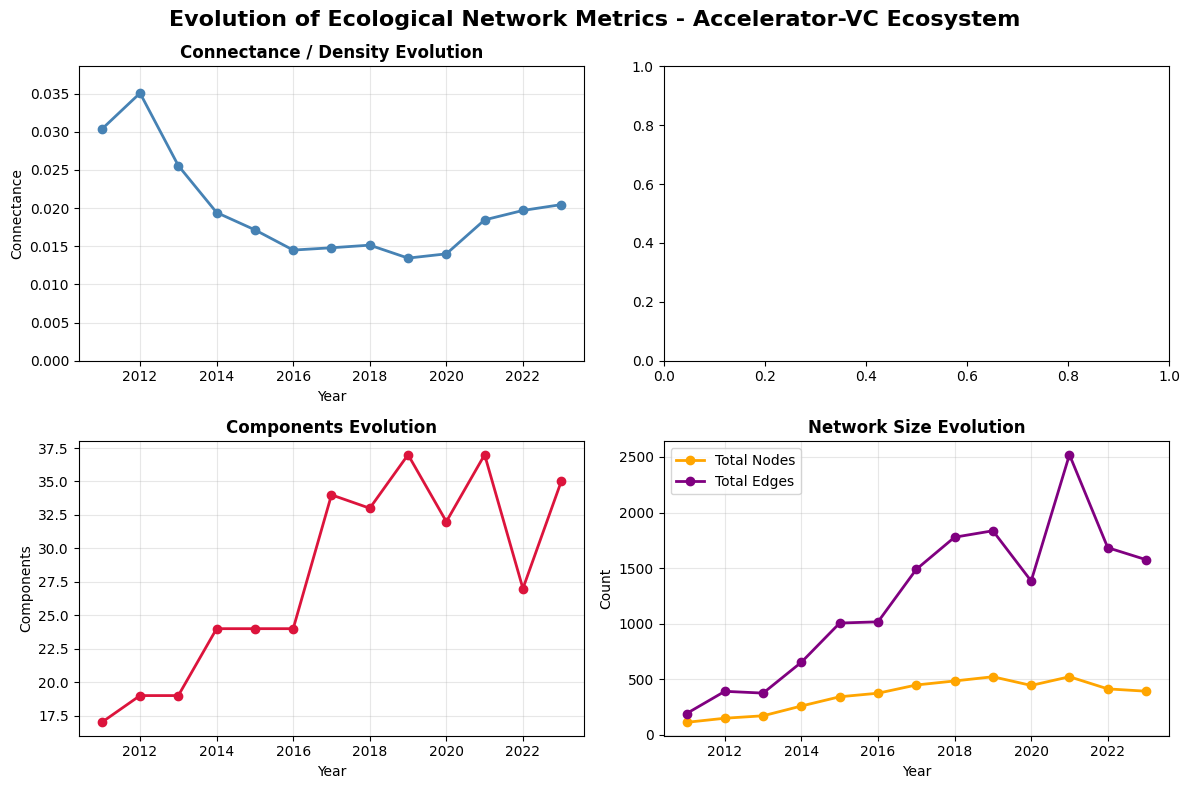

In [17]:
if len(ts_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Evolution of Ecological Network Metrics - Accelerator-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0, 0].plot(ts_df['year'], ts_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0, 0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Connectance')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, max(ts_df['connectance']) * 1.1)
    
    """ # Nestedness evolution
    axes[0, 1].plot(ts_df['year'], ts_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[0, 1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Nestedness (NODF)')
    axes[0, 1].grid(True, alpha=0.3) """
    
    # Modularity evolution
    axes[1, 0].plot(ts_df['year'], ts_df['num_components'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[1, 0].set_title('Components Evolution', fontweight='bold')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Components')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[1, 1].plot(ts_df['year'], ts_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[1, 1].plot(ts_df['year'], ts_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[1, 1].set_title('Network Size Evolution', fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: -0.0008 per year (total: -0.0099)
num_components: +1.5000 per year (total: +18.0000)
num_nodes: +23.3333 per year (total: +280.0000)
num_edges: +115.3333 per year (total: +1384.0000)


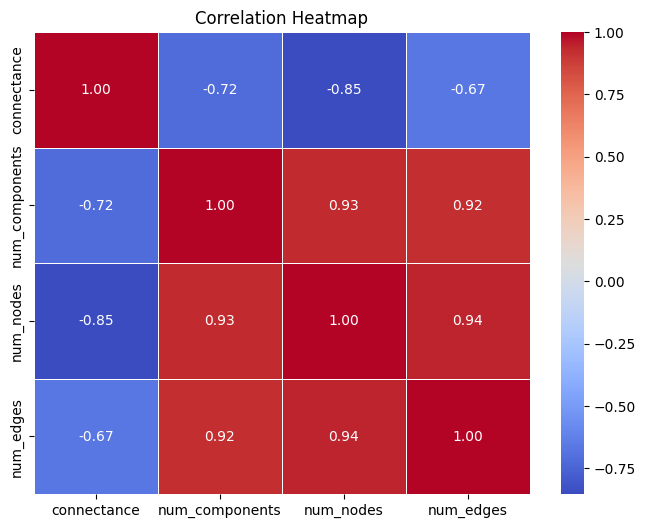

In [18]:
if len(ts_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_df_sorted = ts_df.sort_values('year')
    
    metrics_to_analyze = ['connectance', 'num_components', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in metrics_to_analyze:
        if metric in ts_df_sorted.columns:
            # Calculate differences
            diffs = ts_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_df_sorted[metric].iloc[-1] - ts_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
            
    matrix = ts_df_sorted[metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")

### Cumulative network analysis (5 years window)

In [21]:
# Initialize storage for time series metrics
ts_cumulative_metrics = []
cumulative_window = 5

# Minimum number of edges required for meaningful analysis
min_edges_threshold = 10

print(f"Computing ecological metrics for each year ({cumulative_window} years window)...")
print("=" * 50)

# Loop through each year and calculate metrics
for year in range(min_year, max_year + 1):
    cur_window_acc_vc_inv_pairs = vc_vc_inv_pairs_ts[(vc_vc_inv_pairs_ts['year'] >= year) & (vc_vc_inv_pairs_ts['year'] >= year - cumulative_window)]
    
    try:
        window_edges = extract_bipartite_edges_from_pairs(
            cur_window_acc_vc_inv_pairs,
            'investor_name_left_vc',
            'investor_name_right_vc',
            'total_funding_usd'
        )

        curr_G_vc = nx.Graph()

        for _, row in window_edges.iterrows():
            curr_G_vc.add_edge(row['investor_name_left_vc'], row['investor_name_right_vc'], 
                        weight=row['total_funding_usd'])
    
        
        print(f"\nVC-VC Network Structure:")
        print(f"  Unique VCs: {curr_G_vc.number_of_nodes():,}")
        print(f"  Partnership edges: {curr_G_vc.number_of_edges():,}")
        print(f"  Network density: {nx.density(curr_G_vc):.6f}")
        print(f"  Connected components: {nx.number_connected_components(curr_G_vc)}")
        print(f"  Density: {nx.density(curr_G_vc)}")
        
        # Store metrics for this year
        year_metrics = {
            'year': year,
            'num_nodes': curr_G_vc.number_of_nodes(),
            'num_edges': curr_G_vc.number_of_edges(),
            'connectance': nx.density(curr_G_vc),
            'num_components': nx.number_connected_components(curr_G_vc)
        }
        
        ts_cumulative_metrics.append(year_metrics)
        
        print(f"Year {year}: {year_metrics['num_nodes']} nodes, {year_metrics['num_edges']} edges, "
              f"Connectance: {year_metrics['connectance']:.3f}, "
              f"Components: {year_metrics['num_components']:.1f}, ")
        
    except Exception as e:
        print(f"Year {year}: Error - {str(e)}")
        continue

print(f"\nSuccessfully analyzed {len(ts_cumulative_metrics)} years")

Computing ecological metrics for each year (5 years window)...

VC-VC Network Structure:
  Unique VCs: 1,087
  Partnership edges: 6,862
  Network density: 0.011626
  Connected components: 105
  Density: 0.011625759647330498
Year 2011: 1087 nodes, 6862 edges, Connectance: 0.012, Components: 105.0, 

VC-VC Network Structure:
  Unique VCs: 1,084
  Partnership edges: 6,837
  Network density: 0.011648
  Connected components: 104
  Density: 0.01164763725199579
Year 2012: 1084 nodes, 6837 edges, Connectance: 0.012, Components: 104.0, 

VC-VC Network Structure:
  Unique VCs: 1,077
  Partnership edges: 6,788
  Network density: 0.011715
  Connected components: 102
  Density: 0.01171504212789899
Year 2013: 1077 nodes, 6788 edges, Connectance: 0.012, Components: 102.0, 

VC-VC Network Structure:
  Unique VCs: 1,067
  Partnership edges: 6,714
  Network density: 0.011806
  Connected components: 102
  Density: 0.011805644694757091
Year 2014: 1067 nodes, 6714 edges, Connectance: 0.012, Components: 102

In [22]:
# Convert to DataFrame for easier analysis and plotting
ts_cumulative_df = pd.DataFrame(ts_cumulative_metrics)

if len(ts_cumulative_df) > 0:
    print("Time Series Metrics Summary:")
    print(ts_cumulative_df.describe().round(3))
    
    print(f"\nData available for years: {ts_cumulative_df['year'].min()} to {ts_cumulative_df['year'].max()}")
    print(f"Number of years analyzed: {len(ts_cumulative_df)}")
else:
    print("No time series data available for analysis")

Time Series Metrics Summary:
           year  num_nodes  num_edges  connectance  num_components
count    13.000     13.000     13.000       13.000          13.000
mean   2017.000    912.769   5522.077        0.013          77.308
std       3.894    209.308   1633.204        0.002          25.688
min    2011.000    393.000   1576.000        0.012          35.000
25%    2014.000    854.000   4996.000        0.012          56.000
50%    2017.000    989.000   6147.000        0.013          86.000
75%    2020.000   1067.000   6714.000        0.014         102.000
max    2023.000   1087.000   6862.000        0.020         105.000

Data available for years: 2011 to 2023
Number of years analyzed: 13


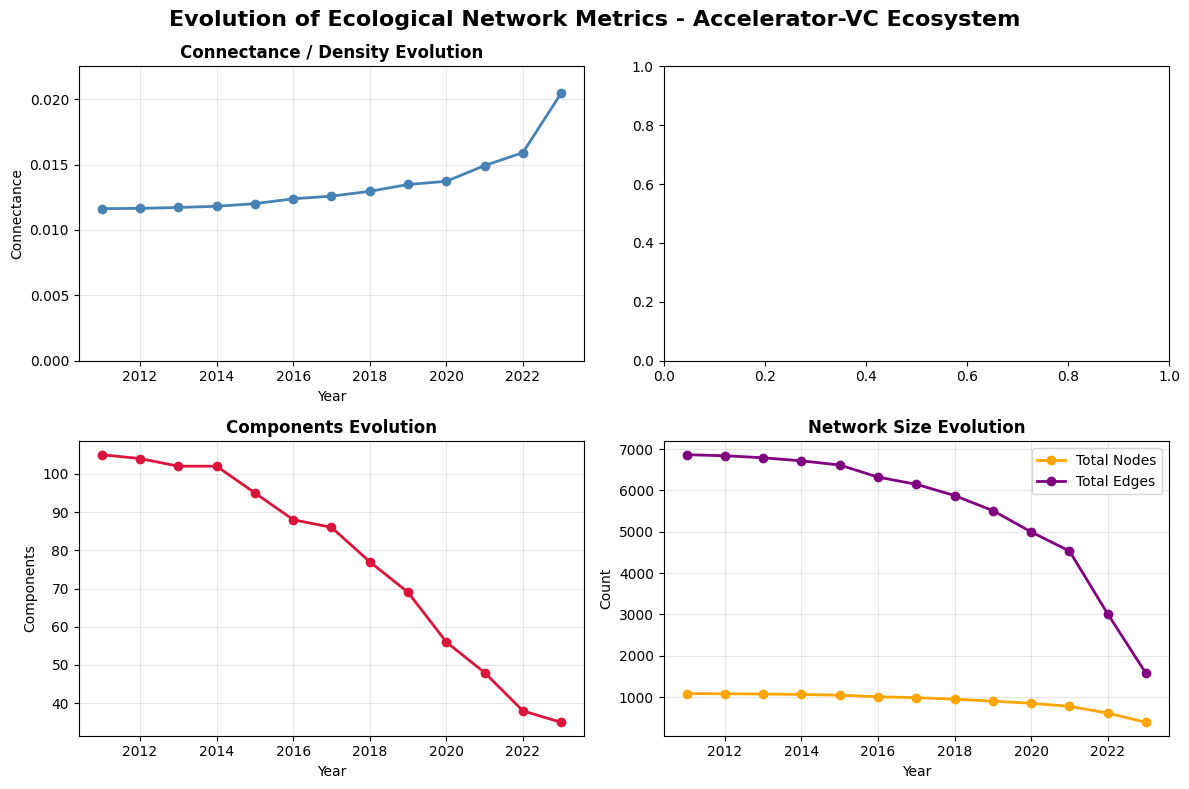

In [23]:
if len(ts_cumulative_df) > 0:
    # Create comprehensive time series plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Evolution of Ecological Network Metrics - Accelerator-VC Ecosystem', 
                 fontsize=16, fontweight='bold')
    
    # Connectance evolution
    axes[0, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['connectance'], 'o-', linewidth=2, markersize=6, color='steelblue')
    axes[0, 0].set_title('Connectance / Density Evolution', fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Connectance')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, max(ts_cumulative_df['connectance']) * 1.1)
    
    # Nestedness evolution
    """ axes[0, 1].plot(ts_cumulative_df['year'], ts_cumulative_df['nestedness_nodf'], 'o-', linewidth=2, markersize=6, color='forestgreen')
    axes[0, 1].set_title('Nestedness (NODF) Evolution', fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Nestedness (NODF)')
    axes[0, 1].grid(True, alpha=0.3) """
    
    # Modularity evolution
    axes[1, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['num_components'], 'o-', linewidth=2, markersize=6, color='crimson')
    axes[1, 0].set_title('Components Evolution', fontweight='bold')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('Components')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Network size evolution
    axes[1, 1].plot(ts_cumulative_df['year'], ts_cumulative_df['num_nodes'], 'o-', linewidth=2, markersize=6, color='orange', label='Total Nodes')
    axes[1, 1].plot(ts_cumulative_df['year'], ts_cumulative_df['num_edges'], 'o-', linewidth=2, markersize=6, color='purple', label='Total Edges')
    axes[1, 1].set_title('Network Size Evolution', fontweight='bold')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    """ axes[2, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['num_accelerators'], 'o-', linewidth=2, markersize=6, 
                color='lightblue', label='Accelerators')
    axes[2, 0].plot(ts_cumulative_df['year'], ts_cumulative_df['num_vcs'], 'o-', linewidth=2, markersize=6, 
                color='lightcoral', label='VCs')
    axes[2, 0].set_title('Accelerators vs VCs Over Time', fontweight='bold')
    axes[2, 0].set_xlabel('Year')
    axes[2, 0].set_ylabel('Number of Actors')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3) """
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for time series visualization")

=== Temporal Trends Analysis ===

Year-over-Year Changes (average):
connectance: +0.0007 per year (total: +0.0088)
num_components: -5.8333 per year (total: -70.0000)
num_nodes: -57.8333 per year (total: -694.0000)
num_edges: -440.5000 per year (total: -5286.0000)


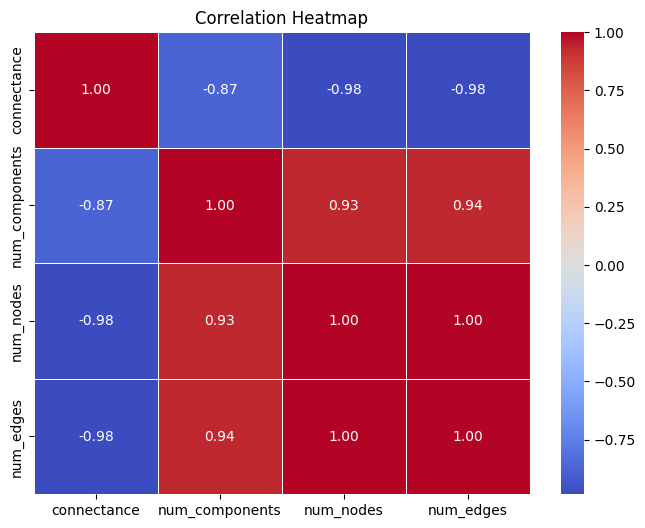

In [24]:
if len(ts_cumulative_df) > 1:
    # Calculate trends and correlations
    print("=== Temporal Trends Analysis ===")
    
    # Calculate year-over-year changes
    ts_cumulative_df_sorted = ts_cumulative_df.sort_values('year')
    
    cumulative_metrics_to_analyze = ['connectance', 'num_components', 'num_nodes', 'num_edges']
    
    print("\nYear-over-Year Changes (average):")
    for metric in cumulative_metrics_to_analyze:
        if metric in ts_cumulative_df_sorted.columns:
            # Calculate differences
            diffs = ts_cumulative_df_sorted[metric].diff().dropna()
            avg_change = diffs.mean()
            total_change = ts_cumulative_df_sorted[metric].iloc[-1] - ts_cumulative_df_sorted[metric].iloc[0]
            print(f"{metric}: {avg_change:+.4f} per year (total: {total_change:+.4f})")
    
    cum_matrix = ts_cumulative_df_sorted[cumulative_metrics_to_analyze].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(cum_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

else:
    print("Insufficient data for temporal trends analysis (need at least 2 years)")